In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model as lm

The cell below outputs the data files

In [2]:
from data_load import Data
load = Data()
load.HOMES_FOR_SALE()
load.INCOME()
load.HOMICIDES()
load.POPULATION()

c:\Users\elang\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading: C:\Users\elang\.cache\kagglehub\datasets\ahmedshahriarsakib\usa-real-estate-dataset\versions\25\realtor-data.zip.csv


In [3]:
buildings = pd.read_csv('Houses_Sold.csv')
buildings.dropna(axis=0, inplace=True)

In [4]:
houses = buildings.loc[ (buildings['bed'] <= 12) & (buildings['bed'] > buildings['bath']) & (buildings['house_size'] <= 5000) & (buildings['house_size'] >= 1000) & (buildings['price'] > 1000) & (buildings['price'] < 10e6), ]

C:\Users\elang\AppData\Local\Temp\1\ipykernel_5028\2721309593.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  houses['size_bins'] = np.round(houses['house_size'],-2)


Text(0.5, 0.01, 'House Square Footage')

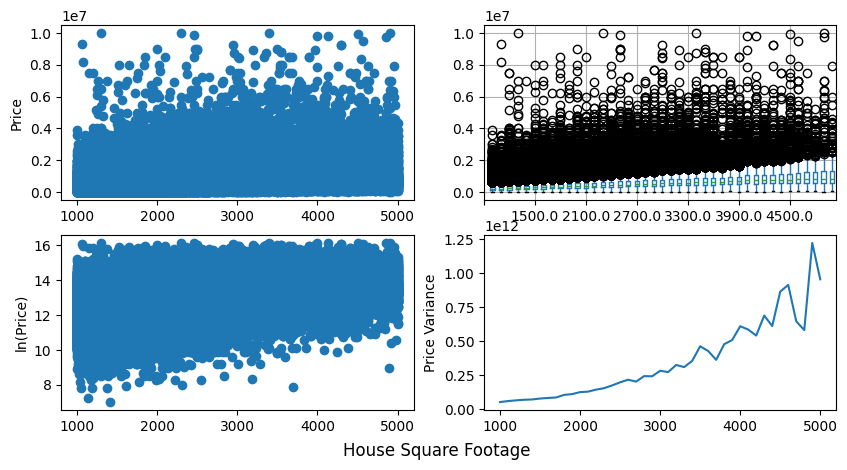

In [5]:
houses['size_bins'] = np.round(houses['house_size'],-2)
price_var = houses.groupby('size_bins')['price'].var().reset_index(name='price_var')
price_var = price_var.sort_values(by='size_bins')
price_by_bin = houses.groupby('size_bins')['price'].apply(list)
df_price_by_bin = pd.DataFrame({str(bin_label): pd.Series(vals)
                                for bin_label, vals in price_by_bin.items()})
sqft = list(price_by_bin.index)
price_ar = df_price_by_bin.to_numpy()

fig, ax = plt.subplots(2,2, figsize=(10,5))
ax[0,0].scatter(houses['house_size'], houses['price'])
ax[0,0].set_ylabel('Price')
df_price_by_bin.boxplot(ax=ax[0,1])
ax[0,1].set_xticks([i for i in range(0, len(sqft)) if (i % 6 == 0) or (i == 0) or (i == len(sqft))])
ax[1,0].scatter(houses['house_size'], np.log(houses['price']))
ax[1,0].set_ylabel('ln(Price)')
ax[1,1].plot(price_var['size_bins'], price_var['price_var'])
ax[1,1].set_ylabel('Price Variance')
fig.supxlabel('House Square Footage')

In [6]:
Income = pd.read_csv('Income_ZipCode.csv')
Income = Income.loc[Income['zipcode'] > 0, :]
Income = Income[['zipcode', 'N1', 'A00100']]
Income['Household_AGI'] = Income['A00100'] / Income['N1']

In [7]:
House_Income = houses.merge(Income, how='left', left_on='zip_code', right_on='zipcode')

In [8]:
zip_pop = pd.read_csv('Zip_Pop.csv')

In [10]:
House_Income_Pop = House_Income.merge(zip_pop[['zip_code','Total_Pop']], how='left', on='zip_code')

In [11]:
homicides = pd.read_csv('HHS_homicides.csv')

In [14]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_tweedie_deviance

In [16]:
House_Income_Pop.dropna(axis=0, inplace=True)
X = House_Income_Pop[['bed', 'bath', 'house_size', 'zip_code', 'acre_lot', 'Household_AGI', 'Total_Pop']]
y = House_Income_Pop['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
XGReg = xgb_reg = xgb.XGBRegressor(
    objective='reg:tweedie',
    tweedie_variance_power=1.75, # Choose a value between 1 and 2 for overdispersed data
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
XGReg.fit(X_train, y_train)
y_pred = XGReg.predict(X_test)

In [18]:
# Evaluate using the Mean Tweedie Deviance
tweedie_deviance = mean_tweedie_deviance(y_test, y_pred, power=1.5)
print(f"Mean Tweedie Deviance: {tweedie_deviance:.4f}")

null_tweedie_deviance = mean_tweedie_deviance(y_test, [y_train.mean()]*len(y_test), power=1.5)
print(f"Null Model Mean Tweedie Deviance: {null_tweedie_deviance:.4f}")
print(f"Percent Deviance Explained: {(1-tweedie_deviance/null_tweedie_deviance)*100:.4f}")

Mean Tweedie Deviance: 60.0778
Null Model Mean Tweedie Deviance: 335.8737
Percent Deviance Explained: 82.1130
